# Table of Contents

1. Import Libraries
2. Load Dataset
3. Preprocessing and Exploring Text Data
  
  3.1 Text Cleaning
  
  3.2 Finding Word Count

  3.3 Find and Replace Rare Words with "Unknown" Token

4. Data Preparation

  4.1 Prepare Sequences

  4.2 Create Token-Integer Mappings

  4.3 Split Data into Train and Validation Sets

  4.4 Pad Sequences

  4.5 Convert Text Sequences to Integer Sequences
5. Model Building

  5.1 Define Model Architecture
  
  5.2 Start Model Training
6. Text Generation

# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
import re
import random

from tqdm import tqdm, notebook # https://www.kaggle.com/questions-and-answers/126888

import torch
from torch import nn
import torch.nn.functional as F

In [2]:
# reproducing same results
SEED = 2019
# torch
torch.manual_seed(SEED)

# 2. Load Dataset

In [3]:
# open text file and read in data
with open("D:/LargeData/Analytics_Vidhya/NLP_Deep/Dailog-dataset.dialogs_dataset", 
          "rb") as f:
    dialogs = pickle.load(f)

Note: This is a subset of the Taskmaster dataset available under the Creative Commons Attribution 4.0 License. A full copy of the license can be found at https://creativecommons.org/licenses/by/4.0/. You can access the full dataset from [here](https://github.com/google-research-datasets/Taskmaster/tree/master/TM-1-2019).  

In [4]:
# Libraries to download CSV from Github
# Skip this.  Not sure how to get the data from original source.

# import requests
# import io
    
# Downloading the csv file from your GitHub account

# url = "https://raw.githubusercontent.com/google-research-datasets/Taskmaster/master/TM-1-2019/self-dialogs.json" # Make sure the url is the raw version of the file on GitHub
# download = requests.get(url).content

# # Reading the downloaded content and turning it into a pandas dataframe

# my_dialogs = pd.read_json(io.StringIO(download.decode('utf-8')))

# # Printing out the first 5 rows of the dataframe

# print (my_dialogs.head())

I do not know how to extract the target data.

In [5]:
# number of text sequences
len(dialogs)

64776

In [6]:
# print 10 random dialogs
random.sample(dialogs, 10)

["Oh no that's not good",
 'Mushrooms, olives, tomatoes, onions',
 'How far is it?',
 " I don't like the texture of them",
 'Ok, about what time?',
 "I'd like to go watch it in Wallingford",
 'My rear headlight seems to be out',
 "That sounds great! It's so nice tonight - do they have outdoor seating?",
 'The one on the Riverside in San Antonio',
 ' Can you please make a reservation for seven tonight?']

# 3. Preprocessing and Exploring Text Data

## 3.1 Text Cleaning

In [7]:
# text cleaning
dialogs_clean = []

for i in dialogs:
  # remove everything except alphabets
  i = re.sub("[^a-zA-Z' ]", "", i) #keeping the apostrophe is not required
  # convert text to lowercase
  i = i.lower()
  # add cleaned text to the list
  dialogs_clean.append(i)

In [8]:
random.sample(dialogs_clean, 10)

['me plus one',
 'hey i need to get my car in to the shop',
 'hi i want movie tickets',
 "nope that's all for right now",
 'yes it is',
 'i would like to order one supreme pizza',
 'have a good one and thanks again',
 'let me know the details',
 'that should be fine',
 'yes use that one']


## 3.2 Finding Word Count

In [9]:
# get list of all the words
all_words = " ".join(dialogs_clean).split() #puts all teh word phrases into one big list of words

all_words[1:10]

["i'm", 'looking', 'to', 'book', 'a', 'table', 'for', 'korean', 'fod']

In [10]:
words_dict = {}

# add word-count pair to the dictionary
for word in all_words:   
  # check if the word is already in dictionary 
  if word in words_dict:
    # increment count of word by 1 
    words_dict[word] = words_dict[word] + 1
  else:
    # add the word to dictionary with count 1 
    words_dict[word] = 1
    


In [11]:
example = {key:value for key, value in words_dict.items() if value >6000}
example

{'to': 14000,
 'a': 13380,
 'for': 7709,
 'the': 15406,
 'is': 6936,
 'that': 8048,
 'it': 7737,
 'i': 19654,
 'and': 6534,
 'you': 11909}

In [12]:
# prepare a dataframe
words_df = pd.DataFrame({'word':list(words_dict.keys()), 'count':list(words_dict.values())})

# sort words by their count in increasing order
words_df = words_df.sort_values(by = ['count'])

# reset dataframe index
words_df.reset_index(inplace = True, drop=True)

In [13]:
# vocabulary size
len(words_df)

11147

In [14]:
words_df.head()

,word,count
0,uppermiddle,1
1,shoots,1
2,geesh,1
3,andrea,1
4,precice,1


In [15]:
words_df.tail()

,word,count
11142,you,11909
11143,a,13380
11144,to,14000
11145,the,15406
11146,i,19654


## 3.3 Find and Replace Rare Words with "Unknown" Token

In [16]:
# user specified threshold value - this reduces vacab size and thereby speeds up training
rare_thresh = 4

# get percentage of rare words in the vocabulary
rare_words_count = len(words_df[words_df['count'] < rare_thresh]['word'])
total_words = len(words_df) 
rare_dist = rare_words_count / total_words

# coverage percentage of rare words in the corpus
rare_cover = words_df[words_df['count'] < rare_thresh]['count'].sum()/words_df['count'].sum()

In [17]:
print(f"Rare words distribution in the vocabulary: {rare_dist*100:.2f}")
print(f"Rare words coverage in the corpus: {rare_cover*100:.2f}")

Rare words distribution in the vocabulary: 69.03
Rare words coverage in the corpus: 2.27


In [18]:
# extract rare words in a list
rare_words = words_df[words_df['count'] < rare_thresh]['word'].tolist()

In [19]:
rare_words[1:15]

['shoots',
 'geesh',
 'andrea',
 'precice',
 'pavilions',
 'perk',
 'lenna',
 'jamestown',
 'athenaeum',
 'fanta',
 'awang',
 'chautauqua',
 'institution',
 "it'"]

Let's see the technique that we will use to replace the rare words/tokens in the dataset with a special token known as the unknown token ("\<unk\>")

In [20]:
## example
# specify rare words
r_words = ["day", "book"]

# build pattern
pattern = ""
for i in r_words:
  pattern+= "{}|".format(i) # creates a list of words seperated by the OR regex syntax

print(pattern)

day|book|


In [21]:
# removing the last element which is "|"
pattern = pattern[:-1]
print(pattern)

day|book


In [22]:
# replace the rare words with the <unk> token
sents = ["it has been a long day", "this book is a must read"]

for d in sents:
  text = re.sub(pattern, " <unk> ", d)
  print(text)

it has been a long  <unk> 
this  <unk>  is a must read


In [23]:
# create a text pattern from the rare words, like "word1 | word2 | word3..."
pattern = ""
for i in rare_words:
  pattern+= " {} |".format(i)

# removing the last element which is "|"
pattern = pattern[:-1]

# empty list 
dialogs_clean_v2 = []

# replace the rare words with the <unk> token
for d in notebook.tqdm(dialogs_clean):
  text = re.sub(pattern, " <unk> ", d)
  dialogs_clean_v2.append(text)

  0%|          | 0/64776 [00:00<?, ?it/s]

In [24]:
dialogs_clean_v2[520:530]

['does it serve traditional chinese dessert',
 'how much extra time to reach <unk> ',
 'ok lets reserve a table for dinner at hakkasan',
 'hello i need to get a car please',
 'holiday inn <unk> parkconv <unk> convention center drive <unk> park il',
 'bowling alley <unk> highway <unk> park il',
 'what types of cars does uber have',
 "what's the price difference",
 'ok get me the cheapest please',
 'ok then get me the next level']

# 4. Data Preparation

## 4.1 Prepare Sequences

<AxesSubplot:>

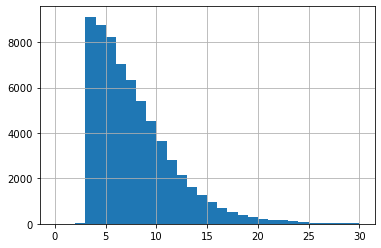

In [25]:
# capture length of all the sequences
text_word_count = []
for i in dialogs_clean_v2:
  text_word_count.append(len(i.split()))
        
# plot the sequence lengths
pd.Series(text_word_count).hist(bins = 30,range=(0,30))

Most sequences are length of 10 or less.  Picking a higher number will cause possible loss of sequential information.

In [26]:
# function to create sequences of equal length 5
def create_seq(text, seq_len = 5):
      
  sequences = []    
  
  if len(text.split()) > seq_len:
    for i in range(seq_len, len(text.split())):
      # select sequence of tokens
      seq = text.split()[i-seq_len:i+1]
      # append sequence to the list
      sequences.append(" ".join(seq))

    return sequences

  else:
    
    return [text]

In [27]:
# create sequences of equal length
seqs = [create_seq(i) for i in dialogs_clean_v2]

A list of lists is returned.

In [28]:
seqs[:10]

[["hi i'm looking to book a",
  "i'm looking to book a table",
  'looking to book a table for',
  'to book a table for korean',
  'book a table for korean fod'],
 ['somewhere in southern nyc maybe the',
  'in southern nyc maybe the east',
  'southern nyc maybe the east village'],
 ["we don't want to sit at",
  "don't want to sit at the",
  'want to sit at the bar',
  'to sit at the bar but',
  'sit at the bar but anywhere',
  'at the bar but anywhere else',
  'the bar but anywhere else is',
  'bar but anywhere else is fine'],
 ['what times are available'],
 ["yikes we can't do those times"],
 ['let me check'],
 ["great let's book that"],
 ["no that's it just book"],
 ['hi i would like to see',
  'i would like to see if',
  'would like to see if the',
  'like to see if the movie',
  'to see if the movie what',
  'see if the movie what men',
  'if the movie what men want',
  'the movie what men want is',
  'movie what men want is playing',
  'what men want is playing here'],
 ['yes for m

In [29]:
# merge list-of-lists into a single list
seqs = sum(seqs, [])

In [30]:
seqs[:15]

["hi i'm looking to book a",
 "i'm looking to book a table",
 'looking to book a table for',
 'to book a table for korean',
 'book a table for korean fod',
 'somewhere in southern nyc maybe the',
 'in southern nyc maybe the east',
 'southern nyc maybe the east village',
 "we don't want to sit at",
 "don't want to sit at the",
 'want to sit at the bar',
 'to sit at the bar but',
 'sit at the bar but anywhere',
 'at the bar but anywhere else',
 'the bar but anywhere else is']

In [31]:
# count of sequences
len(seqs)

205346

In [32]:
# create input and target sequences (x and y)
x = []
y = []

for s in seqs:
  x.append(" ".join(s.split()[:-1])) # first token to 2nd to last token
  y.append(" ".join(s.split()[1:])) #2nd tolken to last token

In [33]:
x[0], y[0]

("hi i'm looking to book", "i'm looking to book a")

In [34]:
x[88543], y[88543]

('to drive to several locations', 'drive to several locations do')

## 4.2 Create Token-Integer Mappings

In [35]:
# create integer-to-token mapping
int2token = {}
cnt = 1

for w in set(" ".join(dialogs_clean_v2).split()):
  int2token[cnt] = w
  cnt+= 1

# create token-to-integer mapping
token2int = {t: i for i, t in int2token.items()}

In [36]:
token2int["can"], int2token[1127]

(3056, 'yeah')

In [37]:
example = {key:value for key, value in int2token.items() if key <11}
example

#example = {key:value for key, value in words_dict.items() if value >6000}

{1: 'received',
 2: 'waters',
 3: 'rusting',
 4: 'groceries',
 5: 'ivy',
 6: 'dinein',
 7: 'ewallet',
 8: 'beans',
 9: 'xerxes',
 10: 'community'}

In [38]:
example = {key:value for key, value in token2int.items() if value <11}
example

{'received': 1,
 'waters': 2,
 'rusting': 3,
 'groceries': 4,
 'ivy': 5,
 'dinein': 6,
 'ewallet': 7,
 'beans': 8,
 'xerxes': 9,
 'community': 10}

## 4.3 Split Data into Train and Validation Sets

In [39]:
# train-validation split
# input sequences
x_tr = x[:150000]
x_val = x[150000:]

# target sequences
y_tr = y[:150000]
y_val = y[150000:]

## 4.4 Pad Sequences

<AxesSubplot:>

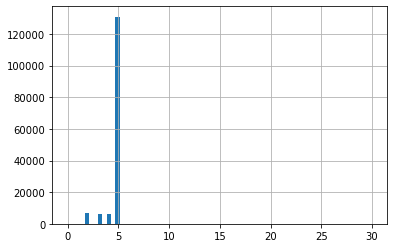

In [40]:
# plot sequence length in train set
text_word_count = []

for i in x_tr:
  text_word_count.append(len(i.split()))

pd.Series(text_word_count).hist(bins = 70,range=(0,30))

The plot above shows there are some sequences with a length less than 5.

In [41]:
# based on the plot above
max_text_len = 5

# function to perform padding
def pad_sequence(seq, n):

  # split input sequence into tokens
  seq = seq.split()
  
  # check if no. of tokens in input sequence is less than 'n'
  if len(seq) < n:
    for i in range(n - len(seq)):
      seq.append("<pad>")

  return " ".join(seq)

# pad text sequences (train set)
x_tr_padded = [pad_sequence(s, max_text_len) for s in x_tr]
y_tr_padded = [pad_sequence(s, max_text_len) for s in y_tr]

# pad text sequences (validation set)
x_val_padded = [pad_sequence(s, max_text_len) for s in x_val]
y_val_padded = [pad_sequence(s, max_text_len) for s in y_val]

In [42]:
x_tr_padded[:20]

["hi i'm looking to book",
 "i'm looking to book a",
 'looking to book a table',
 'to book a table for',
 'book a table for korean',
 'somewhere in southern nyc maybe',
 'in southern nyc maybe the',
 'southern nyc maybe the east',
 "we don't want to sit",
 "don't want to sit at",
 'want to sit at the',
 'to sit at the bar',
 'sit at the bar but',
 'at the bar but anywhere',
 'the bar but anywhere else',
 'bar but anywhere else is',
 'what times are <pad> <pad>',
 "yikes we can't do those",
 'let me <pad> <pad> <pad>',
 "great let's book <pad> <pad>"]

In [43]:
y_tr_padded[:20]

["i'm looking to book a",
 'looking to book a table',
 'to book a table for',
 'book a table for korean',
 'a table for korean fod',
 'in southern nyc maybe the',
 'southern nyc maybe the east',
 'nyc maybe the east village',
 "don't want to sit at",
 'want to sit at the',
 'to sit at the bar',
 'sit at the bar but',
 'at the bar but anywhere',
 'the bar but anywhere else',
 'bar but anywhere else is',
 'but anywhere else is fine',
 'times are available <pad> <pad>',
 "we can't do those times",
 'me check <pad> <pad> <pad>',
 "let's book that <pad> <pad>"]

In [44]:
# update mapping dictionaries
int2token[0] = "<pad>"
token2int["<pad>"] = 0

# set vocabulary size
vocab_size = len(int2token)

## 4.5 Convert Text Sequences to Integer Sequences

In [45]:
# function to create integer sequences
def get_integer_seq(seq):
  return [token2int[w] for w in seq.split()]

In [46]:
# convert text sequences to integer sequences
x_tr_int = [get_integer_seq(i) for i in x_tr_padded]
y_tr_int = [get_integer_seq(i) for i in y_tr_padded]

x_val_int = [get_integer_seq(i) for i in x_val_padded]
y_val_int = [get_integer_seq(i) for i in y_val_padded]

In [47]:
x_tr_int[:10]

[[775, 545, 631, 1531, 2752],
 [545, 631, 1531, 2752, 4181],
 [631, 1531, 2752, 4181, 1613],
 [1531, 2752, 4181, 1613, 4094],
 [2752, 4181, 1613, 4094, 579],
 [3668, 5607, 1156, 4740, 6463],
 [5607, 1156, 4740, 6463, 5078],
 [1156, 4740, 6463, 5078, 37],
 [2340, 3950, 5280, 1531, 1409],
 [3950, 5280, 1531, 1409, 6473]]

In [48]:
y_tr_int[:10]

[[545, 631, 1531, 2752, 4181],
 [631, 1531, 2752, 4181, 1613],
 [1531, 2752, 4181, 1613, 4094],
 [2752, 4181, 1613, 4094, 579],
 [4181, 1613, 4094, 579, 1700],
 [5607, 1156, 4740, 6463, 5078],
 [1156, 4740, 6463, 5078, 37],
 [4740, 6463, 5078, 37, 2277],
 [3950, 5280, 1531, 1409, 6473],
 [5280, 1531, 1409, 6473, 5078]]

In [49]:
# convert lists into numpy arrays
x_tr_int = np.array(x_tr_int)
y_tr_int = np.array(y_tr_int)

x_val_int = np.array(x_val_int)
y_val_int = np.array(y_val_int)

x_tr_int.shape, y_tr_int.shape, x_val_int.shape, y_val_int.shape

((150000, 5), (150000, 5), (55346, 5), (55346, 5))

# 5. Model Building

## 5.1 Define Model Architecture

In [ ]:
# define model architecture

## embedding layer: 
##    input dim = vocab_size, # equal to the distinct words in the training set 
##    ouput dim = 200 # output word embedding or word vectors of length 200

## LSTM layer:
##    input dim = 200
##    hidden units = 256
##    layers = 2
##    output dim = 256 # this is selected by the user.  Can be anything like 128 or 512.

## Dropout Layer
##    input dim = 256
##    output dim = 256

## fully connected layer
##    input dim = 256
##    ouput dim = vocab_size

class WordLSTM(nn.Module):
      
  def __init__(self, n_hidden=256, n_layers=2, drop_prob=0.3, lr=0.001): # these are hyperparameters.  You can change them
    super().__init__()
    self.drop_prob = drop_prob
    self.n_layers = n_layers
    self.n_hidden = n_hidden
    self.lr = lr
    
    self.emb_layer = nn.Embedding(vocab_size, 200)

    ## define the LSTM
    # input data is of shape (batch size, sequence length, no. of features)...
    # ...therefore we need batch_first=True
    self.lstm = nn.LSTM(200, n_hidden, n_layers, batch_first=True)
    # batch_first set to TRUE because because input data shape is 3D. 
    # The 1st is represented by batch size.
    # 2nd is suquence length.
    # 3rd is number of features
    # By default the LSTM layer considers the 1st as sequence length and the 2nd as batch size.
    # However in the batch we pass to this model, the 1st is batch size and 2nd is sequence length.
    # This is reversed so batch_size=True us used
    
    ## define a dropout layer
    self.dropout = nn.Dropout(drop_prob)
    
    ## define the fully-connected layer
    self.fc = nn.Linear(n_hidden, vocab_size)      
  
  def forward(self, x, hidden):
    ''' Forward pass through the network. 
        These inputs are x, and the hidden/cell state is `hidden`. '''

    ## pass input through embedding layer
    embedded = self.emb_layer(x)     
    
    ## Get the outputs and the new hidden state from the lstm
    lstm_output, hidden = self.lstm(embedded, hidden)
    
    ## pass through a dropout layer
    out = self.dropout(lstm_output)
    
    ## reshape the tensor to the shape (batch-size*sequence length, hidden units)
    out = out.reshape(-1, self.n_hidden)

    ## put "out" through the fully-connected layer
    out = self.fc(out)

    # return the final output and the hidden state
    return out, hidden
    
    
  def init_hidden(self, batch_size):
    ''' Initializes hidden state '''
    # Create two new tensors with sizes n_layers x batch_size x n_hidden,
    # initialized to zero, for hidden state and cell state of LSTM
    weight = next(self.parameters()).data

#     if (torch.cuda.is_available()):
#       hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
#                 weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
#     else:
      hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
    
    return hidden

In [ ]:
# define and print the net
net = WordLSTM()
print(net)

In [ ]:
# function to generate batches
def get_batches(arr_x, arr_y, batch_size):
  # iterate through the arrays
  prv = 0
  
  for n in range(batch_size, arr_x.shape[0], batch_size):
    # batch of input sequences
    x = arr_x[prv:n,:]

    # batch of target sequences
    y = arr_y[prv:n,:]

    prv = n
    
    yield x, y

## 5.2 Start Model Training

In [55]:
def train(net, epochs=10, batch_size=32, lr=0.001, print_every=32):
    
    # Try different values of the learning rate (0.0001, 0.005, 0.05, etc)
    # Add one more LSTM layer in the model architecture
    # Try different maximum sequence lengths 7, 8, or 10.
    
    # set initial loss to infinite
    best_valid_loss = float('inf')
    
    # optimizer
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    
    # loss function
    criterion = nn.CrossEntropyLoss()
    
    #   if(torch.cuda.is_available()):
    ## push model to GPU
    #     net.cuda()
    
    counter = 0
    
    net.train()
    
    for e in range(epochs):
        
        # iterate over batches
        for x, y in get_batches(x_tr_int, y_tr_int, batch_size):
            counter+= 1
            
            # convert arrays to tensors
            # inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            # Original code on a local PC results in:
            # Pytorch RuntimeError: Expected tensor for argument #1 'indices' to have scalar type Long;
                # but got CUDAType instead
            inputs, targets = torch.from_numpy(x).long(), torch.from_numpy(y).long()
            
#             if(torch.cuda.is_available()):
#                 # push tensors to GPU
#                 inputs, targets = inputs.cuda(), targets.cuda()
            
            # initialize hidden state
            h = net.init_hidden(batch_size)
            
            # set accumulated gradients to zero
            net.zero_grad()
            
            # get the output from the model
            output, h = net(inputs, h)
            
            # calculate the loss and perform backprop
            loss = criterion(output, targets.view(-1))
            loss.backward()
            
            opt.step()
            
            if counter % print_every == 0:
                
                # Get validation loss
                val_losses = []
                
                net.eval()
                
                for x, y in get_batches(x_val_int, y_val_int, batch_size):
                    #x, y = torch.from_numpy(x), torch.from_numpy(y)
                    x, y = torch.from_numpy(x).long(), torch.from_numpy(y).long()
                    val_h = net.init_hidden(batch_size)
                    
                    inputs, targets = x, y
                    
#                     if(torch.cuda.is_available()):
#                         inputs, targets = inputs.cuda(), targets.cuda()
                        
                    output, val_h = net(inputs, val_h)
                    val_loss = criterion(output, targets.view(-1))
                    val_losses.append(val_loss.item())

        #save the best model
        if np.mean(val_losses) < best_valid_loss:
            best_valid_loss = np.mean(val_losses)
            torch.save(net.state_dict(), 'D:/LargeData/Analytics_Vidhya/NLP_Deep/saved_weights_neural_lstm.pt')

        net.train()

      
        print("Epoch: {}/{}...".format(e+1, epochs),
              "Step: {}...".format(counter),
              "Loss: {:.4f}...".format(loss.item()),
              "ppl: {:.4f} ".format(np.exp(np.mean(val_losses))),
              "Val Loss: {:.4f}".format(np.mean(val_losses)))

In [ ]:
# specify batch size
batch_size = 64

# train the model
train(net, batch_size = batch_size, epochs=10)

# 6. Text Generation

In [61]:
#load weights of best model
path = 'D:/LargeData/Analytics_Vidhya/NLP_Deep/saved_weights_neural_lstm.pt'
net.load_state_dict(torch.load(path))

<All keys matched successfully>

In [70]:
# function to generate one token
def predict(net, tkn, h=None):
    
    # tensor inputs
    x = np.array([[token2int[tkn]]])
    inputs = torch.from_numpy(x).long() # added .long() to work on PC
  
#    if(torch.cuda.is_available()):
#         inputs = inputs.cuda()

    # get the output of the model
    out, h = net(inputs, h)

    # get the token probabilities
    p = F.softmax(out, dim=1).data

#     if(torch.cuda.is_available()):
#         p = p.cpu()

    p = p.numpy()
    sampled_token_index = np.argmax(p, axis = 1)[0]
  
    # return the encoded value of the predicted char and the hidden state
    return int2token[sampled_token_index], h

In [71]:
# function to fetch generated sequence
def sample(net, size = 2, seed_text='it is'):
        
    if(torch.cuda.is_available()):
        net.cuda()
    
    net.eval()

    # batch size is 1
    h = net.init_hidden(1)

    toks = seed_text.split()

    # predict next token
    for t in toks:
      token, h = predict(net, t, h)
    
    toks.append(token)

    # predict subsequent tokens
    for i in range(size-1):
        token, h = predict(net, toks[-1], h)
        toks.append(token)

    return ' '.join(toks)

In [72]:
# seed texts
seeds = ["i want to",
         "how about a cup",
         "i don't want",
         "can you send",
         "my car"]

# number of tokens to generate
num_toks = 6

# text generation
for s in seeds:
  # get generated text from the model
  text_gen = sample(net, num_toks, seed_text=s)
  # print the result
  print("seed text:", s, ">> output:",text_gen)
  print("\n")

seed text: i want to >> output: i want to forrester narrow third rpx striking cattlemans


seed text: how about a cup >> output: how about a cup ellum rpx broly gold raspberry tacovore


seed text: i don't want >> output: i don't want michael tacovore thankfully carryon pizzq carryon


seed text: can you send >> output: can you send michael tacovore thankfully carryon pizzq carryon


seed text: my car >> output: my car michael tacovore inbox carryon crossroads ahead


